# Data 512- A1: Data Curation
-Aniruddha Dutta

In this assignment, we collect monthly traffic data on English Wikipedia from January 1 2008 to August 30 2020. We then process the data and analyze the traffic trends for the desktop and mobile platforms for the collected timeperiod. 
#### Contents:
1. Reading Data
2. Data Processing
3. Analysis: Timeseries Visualization

## 1. Reading Data

In this section we make requests to the APis and store the fetched data into json files

Collect data from two different API endpoints:
- <b>The Legacy Pagecounts API</b> provides access to desktop and mobile traffic data from Janunary 2008 through July 2016.
   [Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts),
   [Endpoint](https://wikimedia.org/api/rest_v1/#/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end)   
- <b>The Pageviews API</b> provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last  month. [Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [Endpoint](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)

Define a function __'api_call'__ which takes the endpoint URL and parameters as input and returns the raw requested data (json format in this case). 

To request the APIs for the desired data, initialize parameters such as the project name corresponding to 'English Wikipedia', the agent is set equal to 'user' to avoid traffic data from web crawlers and spiders.
First,initialize two variables containing the APIs' endpoint URL which will be used to make the requests. Then declare variables with parameter details corresponding to each API and access-site i.e. desktop or mobile.

Then write the fetched data into __'.json'__ files. 



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from pandas.io.json import json_normalize

In [2]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters))
    response = call.json()
    
    return response

In [3]:
#initialize endpoint URLs
endpoint_legacy_URL = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews_URL = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

#declare params
legacy_desktop_params = {"project" : "en.wikipedia.org",
                         "access-site" : "desktop-site",
                         "granularity" : "monthly",
                         "start" : "2008010100",
                         "end" : "2016070100"
                        }
legacy_mobile_params = {"project" : "en.wikipedia.org",
                         "access-site" : "mobile-site",
                         "granularity" : "monthly",
                         "start" : "2008010100",
                         "end" : "2016070100"
                        }

pageviews_desktop_params = {"project" : "en.wikipedia.org",
                            "access" : "desktop",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : "2020100100"
                            }

pageviews_mobileapp_params = {"project" : "en.wikipedia.org",
                            "access" : "mobile-app",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : "2020100100"
                            }
pageviews_mobileweb_params = {"project" : "en.wikipedia.org",
                            "access" : "mobile-web",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : "2020100100"
                            }

#call function 'api_call' to fetch data
legacy_pagecount_desktop = api_call(endpoint_legacy_URL, legacy_desktop_params)
legacy_pagecount_mobile = api_call(endpoint_legacy_URL, legacy_mobile_params)
pageviews_desktop = api_call(endpoint_pageviews_URL, pageviews_desktop_params)
paeviews_mobile_app = api_call(endpoint_pageviews_URL, pageviews_mobileapp_params)
paeviews_mobile_web = api_call(endpoint_pageviews_URL, pageviews_mobileweb_params)


#Write data to .json file
with open('pagecounts_desktop-site_200801-201607.json', 'w') as json_file:
    json.dump(legacy_pagecount_desktop, json_file)

with open('pagecounts_mobile-site_200801-201607.json', 'w') as json_file:
    json.dump(legacy_pagecount_mobile, json_file)

with open('pageviews_desktop_201507-202010.json', 'w') as json_file:
    json.dump(pageviews_desktop, json_file)

with open('pageviews_mobile-app_201507-202010.json', 'w') as json_file:
    json.dump(paeviews_mobile_app, json_file)

with open('pageviews_mobile-web_201507-202010.json', 'w') as json_file:
    json.dump(paeviews_mobile_web, json_file)


## 2. Data Processing
In this step we read the raw json data and process it to combine the data from the two APIs, create some additional calculated feilds and store it in a csv format.

Start by creating a function __'format_json'__ which reads data from the json files we saved in step1, and normalizes them into tabular format. 

Once the data is in tabular format, drop the following columns that are not required for the analysis
- pagecount data: access-site, granularity, project
- pageviews data: access, agent, granularity, project

Then, rename the __'count'__ and __'views'__ columns with their corresponding access-site name and merge the data sets on __'timestamp'__. The traffic data for pagecaount mobile is missing before October 2014 resulting in __NAN__ when mered with the desktop data. Replace the __NAN__ with __0__.
Once the datasets are merged together, perform aggregations to create additional calculated feilds.<br>

Pageviews data:
- mobile-app views + mobile-web views = total mobile views
- desktop views + total mobile views = total site views

Pagecount data:
- desktop count + mobile count = total site count

Next, extract __year__ and __month__ from the timestamp and drop all the non-required columns. Write the processed data into a __csv__ file.


In [4]:
def format_json(json_file):
    with open(json_file, 'r') as json_data:
        data = json.load(json_data)
        
    return json_normalize(data['items'])


In [5]:
pageviews_desktop = format_json('pageviews_desktop_201507-202010.json')
pageviews_mobileapp = format_json('pageviews_mobile-app_201507-202010.json')
pageviews_mobileweb = format_json('pageviews_mobile-web_201507-202010.json')
pagecounts_desktop = format_json('pagecounts_desktop-site_200801-201607.json')
pagecounts_mobile = format_json('pagecounts_mobile-site_200801-201607.json')

In [6]:
#processing pagecounts data
pagecounts_desktop.drop(['access-site','granularity', 'project'], axis = 1, inplace = True)
pagecounts_mobile.drop(['access-site', 'granularity', 'project'], axis = 1, inplace = True)
pagecounts_desktop.rename(columns = {'count':'pagecount_desktop_views'}, inplace = True)
pagecounts_mobile.rename(columns = {'count':'pagecount_mobile_views'}, inplace = True)

pagecounts_df = pd.merge(pagecounts_desktop,pagecounts_mobile, how = 'left' , left_on = 'timestamp', right_on = 'timestamp')
pagecounts_df = pagecounts_df.replace(np.nan,0)
pagecounts_df['pagecount_all_views'] = pagecounts_df['pagecount_desktop_views'] + pagecounts_df['pagecount_mobile_views']


#processing pageviews data
pageviews_desktop.drop(['access','agent','granularity', 'project'], axis = 1, inplace = True)
pageviews_mobileapp.drop(['access','agent','granularity', 'project'], axis = 1, inplace = True)
pageviews_mobileweb.drop(['access','agent','granularity', 'project'], axis = 1, inplace = True)
pageviews_desktop.rename(columns = {'views':'pageview_desktop_views'}, inplace = True)
pageviews_mobileapp.rename(columns = {'views':'pageview_mobileapp_views'}, inplace = True)
pageviews_mobileweb.rename(columns = {'views':'pageviews_mobileweb_views'}, inplace = True)

pageviews_mobile = pd.merge(pageviews_mobileapp,pageviews_mobileweb, how = 'left' , left_on = 'timestamp', right_on = 'timestamp')
pageviews_mobile['pageview_mobile_views'] = pageviews_mobile['pageview_mobileapp_views'] + pageviews_mobile['pageviews_mobileweb_views']
pageviews_mobile.drop(['pageview_mobileapp_views','pageviews_mobileweb_views'], axis = 1, inplace= True)
pageviews_df = pd.merge(pageviews_desktop, pageviews_mobile, how = 'left', left_on = 'timestamp', right_on = 'timestamp')
pageviews_df = pageviews_df.replace(np.nan,0)
pageviews_df['pageview_all_views'] = pageviews_df['pageview_desktop_views'] + pageviews_df['pageview_mobile_views']

#merging pageviews and pagecounts data
wikipedia_traffic = pd.merge(pagecounts_df,pageviews_df, how = 'outer', left_on = 'timestamp', right_on = 'timestamp' )
wikipedia_traffic = wikipedia_traffic.replace(np.nan, 0)

#Extracting year and month from 'timestamp'
wikipedia_traffic['year'] = wikipedia_traffic['timestamp'].str[:4]
wikipedia_traffic['month'] = wikipedia_traffic['timestamp'].str[4:6]
wikipedia_traffic.drop(['timestamp'], axis = 1, inplace = True)

#Write data to csv
wikipedia_traffic.to_csv('en-wikipedia_traffic_200712-202008.csv', index = False, header = True)

## 3. Analysis: Timeseries Visualization
To analyze the trend of the traffic on the English Wikipedia page from Jan 2008 to Aug 2020, we plot a time-series graph using the data processed in step2. 

For the time series graph, we dont need to visualize the missing the data points, so we convert the zeroes back to NAN.

Concatenate the year and month feilds to create a timestamp for the X-axis. Then plot the graph using 'matplotlib', the black color represents the total traffic on all sites, the green line represents the traffic for the desktop and the blue for the mobile.

Define functions to format the ticks of the x and y axes to the derired form.

Text(0, -50, 'May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definitions.')

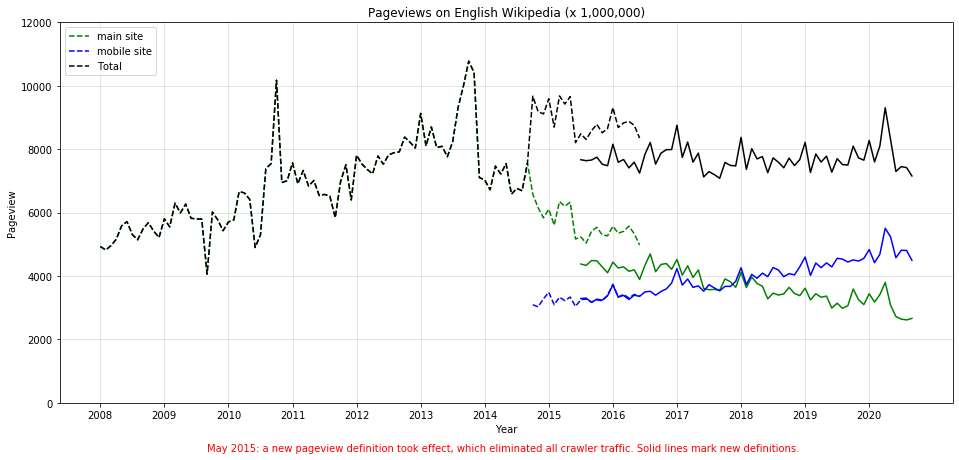

In [10]:
df = wikipedia_traffic.replace(0, np.nan)
df['date'] = df['year'] + df['month']

annotation = 'May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definitions.'

#Plot
myfig, myax = plt.subplots(figsize=(16, 7))

myax.plot( df.date,df.pagecount_desktop_views, color='green', linestyle='--', label='main site')
myax.plot( df.date,df.pagecount_mobile_views, color='blue', linestyle='--', label='mobile site')
myax.plot( df.date,df.pagecount_all_views, color='black', linestyle='--', label='Total')
myax.plot( df.date,df.pageview_all_views, color='black', linestyle='-')
myax.plot( df.date,df.pageview_desktop_views, color='green', linestyle='-')
myax.plot( df.date,df.pageview_mobile_views, color='blue', linestyle='-')

myax.patch.set_facecolor('#FFFFFF')
myax.grid(b=True, which='major', color='#DDDDDD', linestyle='-')

myax.legend(loc='upper left')
myax.set_ylabel('Pageview')
myax.set_xlabel('Year')
title = myax.set_title("Pageviews on English Wikipedia (x 1,000,000)")

#format y-axis ticks
myax.set_ylim(0, 12000000000, 1000000000)

def yaxis_format(y,pos): 
    return "{}".format(int(y/1000000))
myax.yaxis.set_major_formatter(plt.FuncFormatter(yaxis_format))

##format x-axis ticks
myax.xaxis.set_ticks(np.arange(0, 156, 12))
def xaxis_format(x,pos): 
    tick = df['date'][x]
    tick = tick[:4]
    return "{}".format(tick)
myax.xaxis.set_major_formatter(plt.FuncFormatter(xaxis_format))

myax.annotate(annotation, (20,0), (0, -50), textcoords='offset points', color = 'red', va='bottom')
